Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`). 

Use a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Instead of `RidgeRegression`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `RidgeRegression`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module3')

In [2]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [72]:
import pandas as pd
import pandas_profiling
import numpy as np

# Read New York City property sales data
df = pd.read_csv('../data/condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [73]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [74]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [75]:
#    First glance at the data
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,...,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,...,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,...,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,...,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,...,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,...,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [76]:
#    Check shape (rows / columns) of the data
df.shape

(23040, 21)

In [77]:
df = df.drop('EASE-MENT', axis=1)

In [78]:
#    Only the range of sales prices between $100,000 and $2 million are required
df = df[(df['SALE_PRICE']>= 100000) & (df['SALE_PRICE']<= 2000000)]
#    Only need single family homes:
df = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS')]

In [79]:
#    Check shape to see the affect of the pruning.
df.shape

(3164, 20)

In [80]:
#    Check column dtypes
for i, value in enumerate(df):
    print(f'For {value},the type is {df[value].dtype}')

For BOROUGH,the type is object
For NEIGHBORHOOD,the type is object
For BUILDING_CLASS_CATEGORY,the type is object
For TAX_CLASS_AT_PRESENT,the type is object
For BLOCK,the type is int64
For LOT,the type is int64
For BUILDING_CLASS_AT_PRESENT,the type is object
For ADDRESS,the type is object
For APARTMENT_NUMBER,the type is object
For ZIP_CODE,the type is float64
For RESIDENTIAL_UNITS,the type is float64
For COMMERCIAL_UNITS,the type is float64
For TOTAL_UNITS,the type is float64
For LAND_SQUARE_FEET,the type is object
For GROSS_SQUARE_FEET,the type is float64
For YEAR_BUILT,the type is float64
For TAX_CLASS_AT_TIME_OF_SALE,the type is int64
For BUILDING_CLASS_AT_TIME_OF_SALE,the type is object
For SALE_PRICE,the type is int32
For SALE_DATE,the type is object


In [81]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

In [82]:
#    Find mean variance differiential
ignore = ['SALE_PRICE', 'BUILDING_CLASS_CATEGORY']
pdict = {}
for x in df:
  if x in ignore:
    print(f'Skipping {x}.')
    pass
  else:
    print(f'Evaluating {x}.')
    #    Evaluate means
    meanOne = df.groupby(str(x))['SALE_PRICE'].mean()
    meanTwo = df['SALE_PRICE'].mean()
    if len(meanOne) < 2:
        print(f'Skipping {x}, because it failed the mean length test.')
        pass

    #    Set math for mean variance differiential
    else:
        
        totalMean = df.groupby(str(x)).mean()['SALE_PRICE'].mean()
        domain = (meanOne - totalMean)
        meanVar = sum([x**2 for x in domain]) / (len(meanOne) - 1)
        percentVar = ((meanVar**.5)*100) / totalMean
        pdict[x] = percentVar


#   Calculate PVD
p2dict = {}
pdictsums = sum([x for y, x in pdict.items()])

for key, value in pdict.items():
  v2 = (value / pdictsums)
  p2dict[key] = v2

#    Tuple list
PVD = sorted(p2dict.items(), reverse = True, key = lambda x: x[1])

print(f'Done.')

Evaluating BOROUGH.
Evaluating NEIGHBORHOOD.
Skipping BUILDING_CLASS_CATEGORY.
Evaluating TAX_CLASS_AT_PRESENT.
Evaluating BLOCK.
Evaluating LOT.
Evaluating BUILDING_CLASS_AT_PRESENT.
Evaluating ADDRESS.
Evaluating APARTMENT_NUMBER.
Skipping APARTMENT_NUMBER, because it failed the mean length test.
Evaluating ZIP_CODE.
Evaluating RESIDENTIAL_UNITS.
Evaluating COMMERCIAL_UNITS.
Evaluating TOTAL_UNITS.
Evaluating LAND_SQUARE_FEET.
Evaluating GROSS_SQUARE_FEET.
Evaluating YEAR_BUILT.
Evaluating TAX_CLASS_AT_TIME_OF_SALE.
Skipping TAX_CLASS_AT_TIME_OF_SALE, because it failed the mean length test.
Evaluating BUILDING_CLASS_AT_TIME_OF_SALE.
Skipping SALE_PRICE.
Evaluating SALE_DATE.
Done.


In [83]:
import matplotlib.pyplot as plt

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 <a list of 16 Text xticklabel objects>)

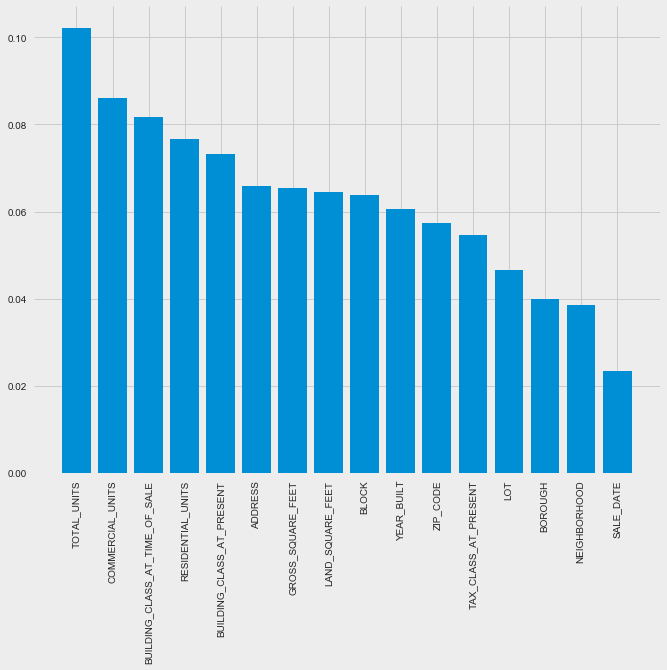

In [84]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (10,8), facecolor = '#ededed')
plt.axes(facecolor = '#ededed', frameon = False)

#  Plot bar graph:
for i, k in enumerate(PVD):
    plt.bar(k[0], k[1], color='C0')
    
plt.xticks(rotation = 90)

In [95]:
for i in PVD[:5]:
    print(f'{i[0]} is type {df[i[0]].dtype}.')
    print(f'{df[i[0]].describe()}')

TOTAL_UNITS is type float64.
count    3164.000000
mean        1.003161
std         0.172362
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: TOTAL_UNITS, dtype: float64
COMMERCIAL_UNITS is type float64.
count    3164.000000
mean        0.015803
std         0.127241
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: COMMERCIAL_UNITS, dtype: float64
BUILDING_CLASS_AT_TIME_OF_SALE is type object.
count     3164
unique      11
top         A1
freq      1189
Name: BUILDING_CLASS_AT_TIME_OF_SALE, dtype: object
RESIDENTIAL_UNITS is type float64.
count    3164.000000
mean        0.987358
std         0.114537
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: RESIDENTIAL_UNITS, dtype: float64
BUILDING_CLASS_AT_PRESENT is type object.
count     3164
unique      13
top         A1
freq      1188
Name: BUILDING_CLASS_AT_

In [96]:
#   I don't need building class at present, only at time of sale. I'll drop that
#   and take square footage instead. I also want land square footage!

checks = ['GROSS_SQUARE_FEET', 'LAND_SQUARE_FEET']
for x in checks:
    print(df[x].describe())

count    3164.000000
mean     1469.718394
std       586.645088
min         0.000000
25%      1144.000000
50%      1360.000000
75%      1683.000000
max      7875.000000
Name: GROSS_SQUARE_FEET, dtype: float64
count      3164
unique     1037
top       4,000
freq        290
Name: LAND_SQUARE_FEET, dtype: object


In [98]:
#    GSF is good. Need to get the LSF as an integer instead of a string.
def lsf_to_int(string):
    assert type(string) == str
    x = string.replace(',', '')
    return int(x)
df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].apply(lsf_to_int)

In [102]:
df['LAND_SQUARE_FEET'].describe()

count     3164.000000
mean      3110.752212
std       1790.452745
min          0.000000
25%       2000.000000
50%       2541.500000
75%       4000.000000
max      18906.000000
Name: LAND_SQUARE_FEET, dtype: float64

In [156]:
features = ['TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'LAND_SQUARE_FEET',
            'COMMERCIAL_UNITS', 'RESIDENTIAL_UNITS','BLOCK']

In [160]:
#     Instantiate the ridge regression model
model = Ridge(alpha=1)

In [161]:
#    10 fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [162]:
#    Define features and target
X = features
y = 'SALE_PRICE'
#     Run model through and get metrics
r2 = [0]
mse = [0]
pred = [0]

for train_index, test_index in kf.split(df[X]):
    X_train, X_test = df[X].iloc[train_index], df[X].iloc[test_index]
    y_train, y_test = df[y].iloc[train_index], df[y].iloc[test_index]
    
    ridgeReg = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    if mse == [0]:
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        pred = y_pred
    else:
        if mean_squared_error(y_test, y_pred) < mse:
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            pred = y_pred
            fModel = ridgeReg
print(f'MSE of ${mse:,.2f}')
print(f'R2 of {(r2*100):,.2f}%')
print(f'The model is {fModel}.')
    

MSE of $54,501,552,942.52
R2 of 17.47%
The model is Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001).


In [ ]:
#    Submitting the assignment like this to make sure it's in. Will update later.